In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from commando import ComManDo
from commando.evaluation import generate_figure, test_partial
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-04-26 20:51:56.979830: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-26 20:51:56.979865: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
np.random.seed(42)

In [3]:
# Load data (visual)
human_cells = pd.read_csv("../data/patchseq_human_L23/human_IVSCC_excitatory_L23_consolidated_0131.csv", index_col=0)
human_morph = pd.read_csv("../data/patchseq_human_L23/All_L23_Lockdown_all_raw_features.csv", index_col=0)
ephys = pd.read_csv("../data/patchseq_human_L23/human_mouse_ephys_all_0127.csv", index_col=0)
sample_names = list(set(human_cells.index) & set(human_morph.index) & set(ephys.index))
data1 = human_morph.loc[sample_names]
data2 = ephys.loc[sample_names]
type1 = type2 = np.array(human_cells.loc[sample_names]['contaminationType'])  # medical_conditions, contaminationType

# Labels
labels = [type1, type2]

# Preprocessing
data1 = np.nan_to_num(preprocessing.scale(data1, axis=0))
data2 = np.nan_to_num(preprocessing.scale(data2, axis=0))
dataset = [data1, data2]

# Utility
positivize = lambda X: [(1 + preprocessing.scale(1 + x)) / 2 for x in X]

In [4]:
# Reduced Priors
full_priors = np.eye(len(dataset[0]))

random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)

none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

# Vars
reduced_dim = 32
batch_size = 50
pca_dim = None

# ComManDo

In [5]:
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 2000,
    'log_DNN': 500,
    'use_early_stop': False,
    'batch_size': batch_size,
    'pca_dim': pca_dim,
    'dist_method': 'euclidean',
}
cm = ComManDo(**kwargs)
cm_data = cm.fit_transform(dataset=dataset)
cm_data_half = ComManDo(**kwargs, P=half_priors, match_result=cm.match_result, PF_Ratio=.5).fit_transform(dataset=dataset)
cm_data_none = ComManDo(**kwargs, P=none_priors, match_result=cm.match_result, PF_Ratio=0).fit_transform(dataset=dataset)

use random seed: 666
Shape of Raw data
Dataset 0: (103, 60)
Dataset 1: (103, 18)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.4074 alpha:0.5585
epoch:[1000/2000] err:0.3769 alpha:0.5754
epoch:[1500/2000] err:0.3589 alpha:0.5865
epoch:[2000/2000] err:0.3369 alpha:0.5959
Finished Matching!
---------------------------------
Train coupled autoencoders
epoch:[500/2000]: loss:0.952342
epoch:[1000/2000]: loss:0.805851
epoch:[1500/2000]: loss:0.809416
epoch:[2000/2000]: loss:0.800387
Finished Mapping!
---------------------------------
ComManDo Done!
Distance: 0.02316018800047459
Correspondence: 0.6405882709987054
Mapping: 18.012483529999372
Total: 18.676231988998552

use random seed: 666
Shape of Raw data
Dataset 0: (103, 60)
Dataset 1: (103, 18)
---------------------------------
Train coupled autoencoders
epoch:[500/2000]: loss:0.970455
epoch:[1000/2000]: loss:0.813612
epoch:[1500/2000]: loss:0.784446
epoch:[2000/2000

# Comparison Methods

In [6]:
# Unioncom
uc = ComManDo(project_mode='tsne', output_dim=reduced_dim)
uc_data = uc.fit_transform(dataset=positivize(dataset))

# NLMA
nlma_data, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim)
nlma_data_half, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim, corr=half_priors)

use random seed: 666
Shape of Raw data
Dataset 0: (103, 60)
Dataset 1: (103, 18)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.4076 alpha:0.5600
epoch:[1000/2000] err:0.3761 alpha:0.5774
epoch:[1500/2000] err:0.3572 alpha:0.5889
epoch:[2000/2000] err:0.3328 alpha:0.5988
Finished Matching!
---------------------------------
Begin finding the embedded space
epoch:[10/100]: loss:1.209706, align_loss:0.090631
epoch:[20/100]: loss:1.112684, align_loss:0.077716
epoch:[30/100]: loss:0.981669, align_loss:0.079693
epoch:[40/100]: loss:1.001930, align_loss:0.071705
epoch:[50/100]: loss:0.990545, align_loss:0.074800
epoch:[60/100]: loss:0.955851, align_loss:0.074231
epoch:[70/100]: loss:0.985599, align_loss:0.074607
epoch:[80/100]: loss:0.935285, align_loss:0.072969
epoch:[90/100]: loss:0.923122, align_loss:0.072070
epoch:[100/100]: loss:0.961299, align_loss:0.066973
Done
---------------------------------
ComManDo Done!
Dis

# Figure Generation

/home/thema/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:290: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= np.linalg.norm(y)
/home/thema/miniconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:290: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= np.linalg.norm(y)


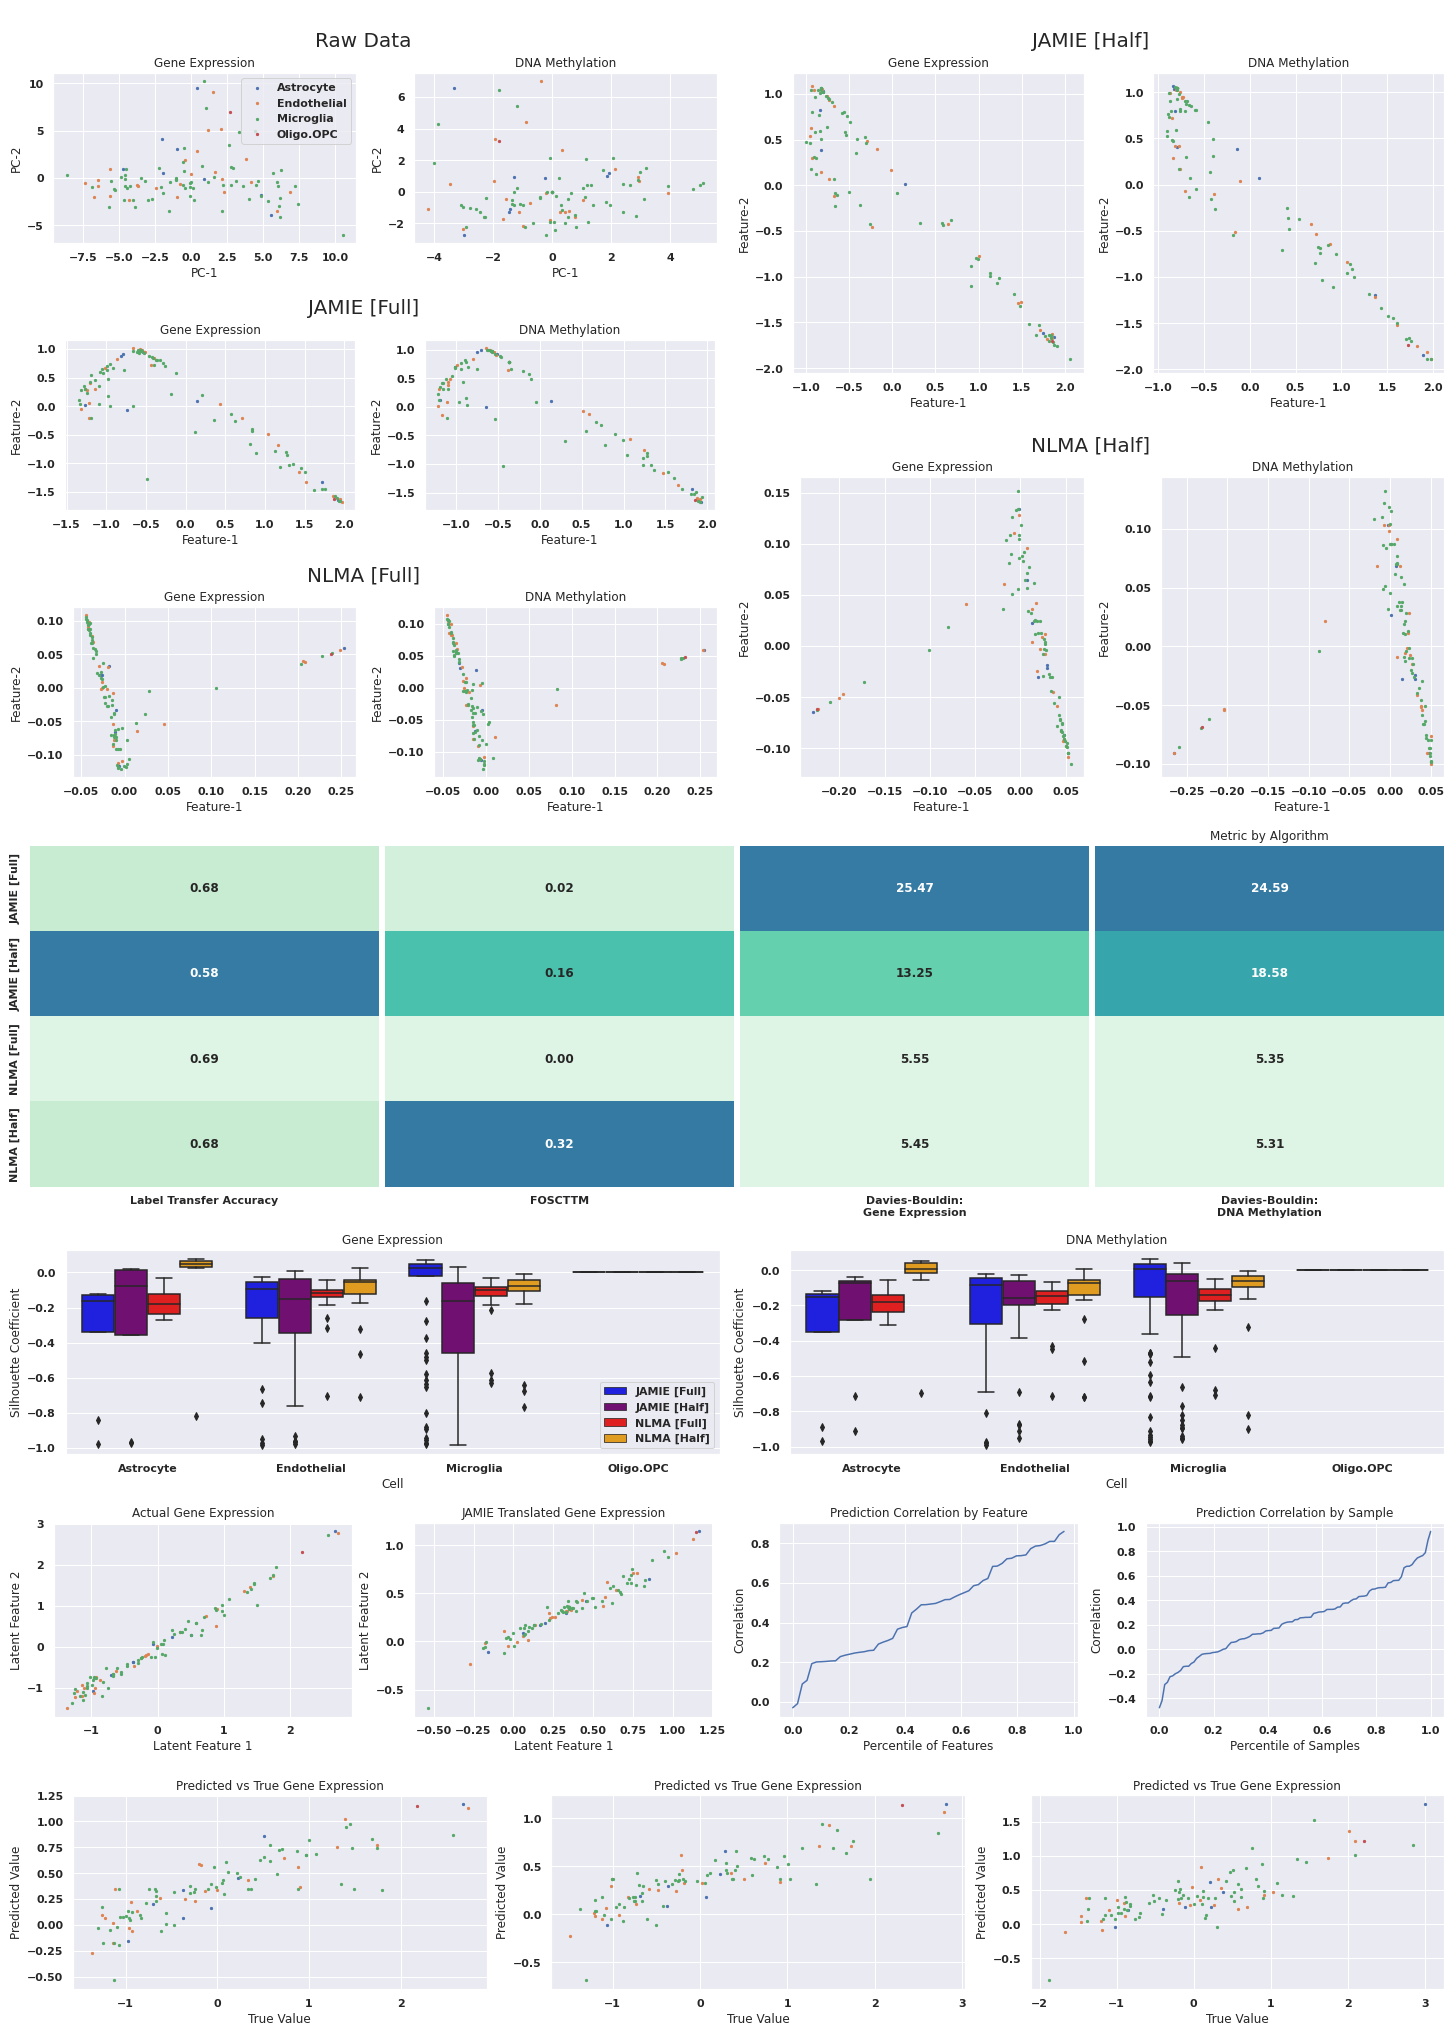

In [7]:
#%%capture --no-display
params = {
    'dataset_names': ['Gene Expression', 'DNA Methylation'],
    'integrated_data': [cm_data, cm_data_half, nlma_data, nlma_data_half],
    'integrated_alg_names': ['JAMIE [Full]', 'JAMIE [Half]', 'NLMA [Full]', 'NLMA [Half]'],
    'colors': ['blue', 'purple', 'red', 'orange'],
    'alg_groups': [0, 1, 0, 1],
    'raw_data_group': 0,
    'integrated_rows': 1,
    'scale': 20,
    # 'integrated_use_pca': True,
    'exclude_predict': [(0, 1)],
    'skip_partial': True,
    'skip_nn': True,
    'skip_simple': True,
}
generate_figure(cm, dataset, labels, **params);